In [1]:
import sys
import os
import numpy as np
import torch
from torch import device, nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os import mkdir
import torch.optim as optim
import scipy
import matplotlib
import plotly.express as px
import pandas as pdfr
from sklearn.metrics import f1_score
import gc
import sklearn
import pandas as pd
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/IHDA/Required_Functions')
sys.path.append('/content/drive/MyDrive/IHDA/Required_Functions/VAE')
sys.path.append('/content/drive/MyDrive/IHDA/Required_Functions/FC')
sys.path.append('/content/drive/MyDrive/IHDA/Required_Functions/Potential')
sys.path.append('/content/drive/MyDrive/IHDA/Required_Functions/Load_Process_Data')
sys.path.append('/content/drive/MyDrive/IHDA/Required_Functions/Hyperparametersearch')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import VAE
import basic_functions
import load_process_data as lpd
import train_VAE
import losses
import eval_VAE
import FC
import eval_FC
import potential
import eval_potential
import retrain_FC
import hyperparameter_search as hps

In this notebook the hyperparameter search for the distance parameter w is performed. w represents the distance. All samples that are within this distance of a considered sample are for calculting its potential. The goal of this notebook is to find from a set of values for w, the one that results in the a set of samples with positive potential, which used for retraining the classifier results in a highest accuracy score.

#**Load training, validation and testing data:**

Following the different datasets are loaded. Here a short definition of the datasets:: 

*   **Training Dataset:** The sample of data used to fit the model.
*  **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
*   **Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.



In [3]:
dir_folder_fc_base = '/content/drive/MyDrive/IHDA/Baseline_classifier/Classifier/'
dir_data_pp        = dir_folder_fc_base + 'Data/'
batch_size         = 500 # batch_size for dataloader

For speeding up the code simply load normalized data and do not precompute it.

In [4]:
x_train = torch.load(dir_data_pp + 'x_train.pth')
y_train = torch.load(dir_data_pp + 'y_train.pth')
x_train_upsample = torch.load(dir_data_pp + 'x_train_upsample.pth')
y_train_upsample = torch.load(dir_data_pp + 'y_train_upsample.pth')

x_validate = torch.load(dir_data_pp + 'x_validate.pth')
y_validate = torch.load(dir_data_pp + 'y_validate.pth')
x_validate_upsample = torch.load(dir_data_pp + 'x_validate_upsample.pth')
y_validate_upsample = torch.load(dir_data_pp + 'y_validate_upsample.pth')

x_test = torch.load(dir_data_pp + 'x_test.pth')
y_test = torch.load(dir_data_pp + 'y_test.pth')

Decide whether classifier VAE should be trained on balanced dataset:

In [15]:
idx_rand = np.random.randint(0,len(x_train_upsample),int(0.1*len(x_train_upsample)))

upsample_state = 1
if upsample_state == 1:
  x_train = x_train_upsample
  y_train = y_train_upsample

  x_validate = x_validate_upsample
  y_validate = y_validate_upsample

Uses loaded datasets to generate dataloaders:

In [16]:
trainloader            = lpd.generate_dataloader(x_train,y_train, batch_size, shuffle = True)
validationloader       = lpd.generate_dataloader(x_validate, y_validate, batch_size, shuffle = True)
testloader             = lpd.generate_dataloader(x_test, y_test, batch_size, shuffle = True)
trainloader_no_shuffle = lpd.generate_dataloader(x_train,y_train, batch_size, shuffle = False)

#**Load trained VAE:**

Specify Hyperparameter of VAE:

In [17]:
# Hyperparameter VAE:
latent_dims = 8
epochs_VAE  = 80       # number of epochs
beta        = 0.025    #0.0005   # 0.005 beta of VAE
lr          = 0.0001   # Learning rate of VAE 
layer       = 1        # layer to optimize
device      = 'cuda'   # device on which the training is performed
dropout_ratio_1 = 0.25 # Dropout ratio

# Directory of trained VAE:
dir_VAE_1 = '/content/drive/MyDrive/Colab_Notebooks/Experiments/Results/IHDA/FC_'+str(layer)+'/VAE/VAE_beta_'+str(beta) + '_latent_dims_' + str(latent_dims) + '_epochs_' + str(epochs_VAE) +'/' + 'best_model.pth'

# Direcotory of base classifier:
dir_fc_base        = dir_folder_fc_base + 'best_model.pth' 

Initialize VAE:

In [18]:
# Load and initialize trained VAE:
VAE_1  = VAE.VariationalAutoencoder(latent_dims,dropout_ratio_1).to(device)
VAE_1  = basic_functions.initialize_model(VAE_1,dir_VAE_1)
VAE_1.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (batch1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=753, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=500, bias=True)
    (fc4): Linear(in_features=500, out_features=8, bias=True)
    (fc5): Linear(in_features=500, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=500, bias=True)
    (fc4): Linear(in_features=500, out_features=753, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

#**Hyperparametersearch:**

Find points with positive potential, by iterating through specified ws. Results are stored.

In [38]:
#Hyperparameter hyperparametersearch:
ws = [0.9999, 0.99992, 0.99994, 0.99996, 0.99998, 0.99999]
#ws     = # [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,0.99,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999,0.9999]
ws = [0.1,0.2,0.3,0.4,0.5,0.7,0.9,0.999972,0.999973,0.999974,0.999975,0.999976,0.999977,0.999978,0.999979,0.99998,0.999981,0.999982,0.999983,0.999984,0.999985,0.999986,0.999987,0.999988,0.999989,0.99999]
ws = [0.2,0.3,0.4,0.5,0.7,0.9,0.999972,0.999973,0.999974,0.999975,0.999976,0.999977,0.999978,0.999979,0.99998,0.999981,0.999982,0.999983,0.999984,0.999985,0.999986,0.999987,0.999988,0.999989,0.99999]
ws = [0.95]
# Hyperparameter potential:
gamma       = 0.05  # Hyperparameter for potential 
dist_metric = nn.CosineSimilarity(dim = 1) # Attention!! If different is used!

# Hyperparameter retraining:
epochs_retrain = 10

# hyperparameter search is performed if hyperparameter_search_state = 1
hyperparameter_search_state = 1
dir_hyper_folder            = '/content/drive/MyDrive/Colab_Notebooks/Experiments/Results/IHDA/FC_1/Hyperparameter/' # Directory of folder called hyperparameter

For the hyperpaprameter search, the training data needs to be mapped to the latent space of the VAE.

In [39]:
# Map data to latent space: 
# IMPORTANT: Dataloader should not be shuffled! Otherwise Z_train and Y_train do not match
Z_train = potential.map_dataloader_to_latent(trainloader_no_shuffle,VAE_1,device)

Start hyperparameter search:

Progress: 0/416776
Progress: 10000/416776
Progress: 20000/416776
Progress: 30000/416776
Progress: 40000/416776
Progress: 50000/416776
Progress: 60000/416776
Progress: 70000/416776
Progress: 80000/416776
Progress: 90000/416776
Progress: 100000/416776
Progress: 110000/416776
Progress: 120000/416776
Progress: 130000/416776
Progress: 140000/416776
Progress: 150000/416776
Progress: 160000/416776
Progress: 170000/416776
Progress: 180000/416776
Progress: 190000/416776
Progress: 200000/416776
Progress: 210000/416776
Progress: 220000/416776
Progress: 230000/416776
Progress: 240000/416776
Progress: 250000/416776
Progress: 260000/416776
Progress: 270000/416776
Progress: 280000/416776
Progress: 290000/416776
Progress: 300000/416776
Progress: 310000/416776
Progress: 320000/416776
Progress: 330000/416776
Progress: 340000/416776
Progress: 350000/416776
Progress: 360000/416776
Progress: 370000/416776
Progress: 380000/416776
Progress: 390000/416776
Progress: 400000/416776
Progress: 410000/416776


/content/drive/MyDrive/IHDA/Required_Functions/Hyperparametersearch/hyperparameter_search.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  potential_ = potential.main_potential(Z_train,y_train,w,gamma,dist_metric,device)
/content/drive/MyDrive/IHDA/Required_Functions/Hyperparametersearch/hyperparameter_search.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  potential_ = potential.main_potential(Z_train,y_train,w,gamma,dist_metric,device)


Epoch [0], train_loss: 1.8078,train_acc: 0.4545,train_f1: 0.5831,valid_loss: 1.4383, valid_acc: 0.8366, valid_f1:0.9049

Best validation loss: 0.8365659425335545

Saving best model for epoch: 1

Epoch [1], train_loss: 2.1253,train_acc: 0.1475,train_f1: 0.1561,valid_loss: 2.0405, valid_acc: 0.2289, valid_f1:0.2749
Epoch [2], train_loss: 2.1312,train_acc: 0.1424,train_f1: 0.1458,valid_loss: 2.0718, valid_acc: 0.1991, valid_f1:0.2405
Epoch [3], train_loss: 2.1312,train_acc: 0.1424,train_f1: 0.1458,valid_loss: 2.0935, valid_acc: 0.1757, valid_f1:0.2063
Epoch [4], train_loss: 2.1310,train_acc: 0.1424,train_f1: 0.1458,valid_loss: 2.0896, valid_acc: 0.1777, valid_f1:0.2077
Epoch [5], train_loss: 2.1282,train_acc: 0.1453,train_f1: 0.1501,valid_loss: 2.0542, valid_acc: 0.2165, valid_f1:0.2418
Epoch [6], train_loss: 2.1287,train_acc: 0.1448,train_f1: 0.1492,valid_loss: 2.0546, valid_acc: 0.2181, valid_f1:0.2421
Epoch [7], train_loss: 2.1274,train_acc: 0.1461,train_f1: 0.1511,valid_loss: 2.0378, 

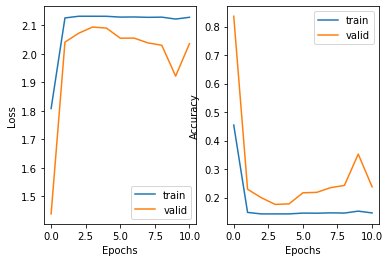

Epoch [0], train_loss: 1.5419,train_acc: 0.7346,train_f1: 0.8382,valid_loss: 1.4383, valid_acc: 0.8366, valid_f1:0.9049

Best validation loss: 0.8365659425335545

Saving best model for epoch: 1

Epoch [1], train_loss: 1.7780,train_acc: 0.4915,train_f1: 0.5913,valid_loss: 1.6326, valid_acc: 0.6393, valid_f1:0.7134
Epoch [2], train_loss: 1.7853,train_acc: 0.4807,train_f1: 0.5889,valid_loss: 1.6885, valid_acc: 0.5796, valid_f1:0.6722
Epoch [3], train_loss: 1.7829,train_acc: 0.4819,train_f1: 0.5910,valid_loss: 1.6843, valid_acc: 0.5844, valid_f1:0.6773
Epoch [4], train_loss: 1.7807,train_acc: 0.4847,train_f1: 0.5923,valid_loss: 1.6929, valid_acc: 0.5761, valid_f1:0.6673
Epoch [5], train_loss: 1.7767,train_acc: 0.4895,train_f1: 0.5967,valid_loss: 1.6921, valid_acc: 0.5757, valid_f1:0.6662
Epoch [6], train_loss: 1.7764,train_acc: 0.4902,train_f1: 0.5958,valid_loss: 1.6924, valid_acc: 0.5754, valid_f1:0.6648
Epoch [7], train_loss: 1.7752,train_acc: 0.4914,train_f1: 0.5961,valid_loss: 1.6951, 

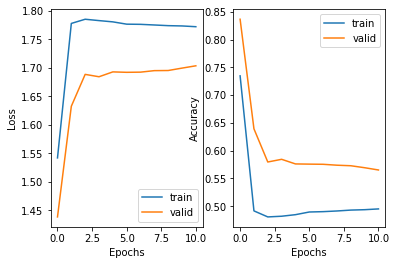

In [40]:
if hyperparameter_search_state == 1:
  hps.main_hyperparamter_w(ws,x_train,y_train,x_validate,y_validate,x_test,y_test,Z_train, gamma,dist_metric, device,dir_hyper_folder,dir_fc_base,epochs_retrain,dir_VAE_1,VAE_1,batch_size)

**Evaluate hyperparametersearch:**

In [24]:
ws = [0.2,0.3,0.4,0.5,0.7,0.9]#,0.999972,0.999973,0.999974,0.999975,0.999976,0.999977,0.999978,0.999979,0.99998,0.999981,0.999982,0.999983,0.999984,0.999985,0.999986,0.999987,0.999988,0.999989,0.99999]
test_acc_pot, valid_acc_pot, test_loss_pot, valid_loss_pot, test_acc_pot_rec, valid_acc_pot_rec, test_loss_pot_rec, valid_loss_pot_rec, ws = hps.split_results(dir_hyper_folder, ws)

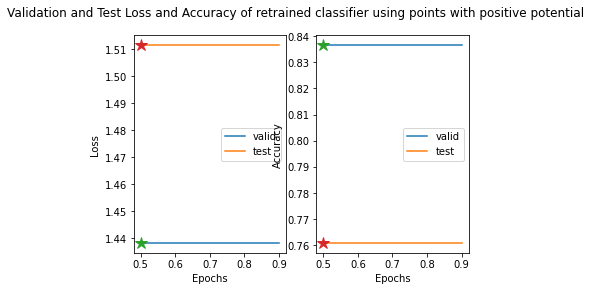

In [25]:
idx = 3

title = 'Validation and Test Loss and Accuracy of retrained classifier using points with positive potential'
hps.plot_hyperparameter_losses(test_acc_pot[idx:], valid_acc_pot[idx:], test_loss_pot[idx:], valid_loss_pot[idx:], ws[idx:],title)

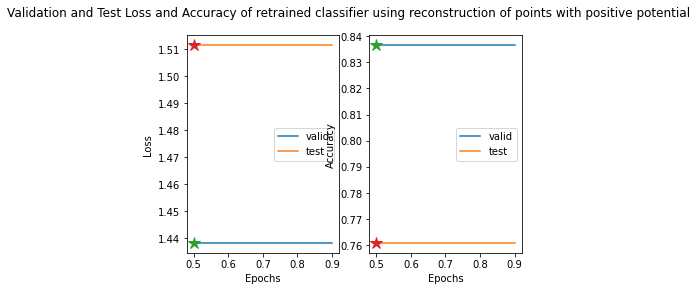

In [26]:
title = 'Validation and Test Loss and Accuracy of retrained classifier using reconstruction of points with positive potential'
hps.plot_hyperparameter_losses(test_acc_pot_rec[idx:], valid_acc_pot_rec[idx:], test_loss_pot_rec[idx:], valid_loss_pot_rec[idx:], ws[idx:],title)

Evaluate baseline classifier:

In [27]:
criterion = nn.CrossEntropyLoss()
fc_base  = FC.FC(dropout_ratio_1).to(device)
fc_base  = basic_functions.initialize_model(fc_base,dir_fc_base)
valid_loss_base, valid_acc_base, valid_f1_base = eval_FC.test_classifier(validationloader,fc_base, device,criterion)
test_loss_base, test_acc_base, test_f1_base = eval_FC.test_classifier(testloader,fc_base, device,criterion)

Print stats from optimization of first layer:

In [28]:
df = hps.print_stats(valid_acc_pot,test_acc_pot,valid_acc_pot_rec,test_acc_pot_rec,test_acc_base,valid_acc_base,ws,dir_hyper_folder)
df

,Optimal w,Validation Accuracy base,Optimal validation accuracy,Valid Accuracy Improvement,Test Accuracy Base,Test accuracy belonging to optimal w,Test Accuracy Improvement,Maximum test accuracy,Number of potential points
Retrain on potential points,0.2,0.836797,0.836566,-0.000231,0.760822,0.760832,0.00001,0.760832,224135
Retrain on reconstructions of potential points,0.2,0.836797,0.836566,-0.000231,0.760822,0.760832,0.00001,0.760832,224135


#**Evaluate specific potential dataset:**

In this section the potential dataset belonging to the specified w_eval will be analyzed.

Specify and laod results:

In [29]:
w_eval = 0.1		

dir_results_eval_w = dir_hyper_folder + 'w_'+ str(w_eval) +'/results_w_'+ str(w_eval) +'.pth' 

results_w_eval = torch.load(dir_results_eval_w)
potential_w_eval = results_w_eval['potential']

Extract points with postive potential:

In [31]:
X_pot, Y_pot, Z_pot, X_no_pot, Y_no_pot, Z_no_pot = potential.split_potential(x_train,y_train,Z_train,potential_w_eval,device = 'cuda')

Generate dataloader containing X_pot, X_no_pot and both combined.

In [32]:
trainloader_pot        = lpd.generate_dataloader(X_pot,Y_pot, batch_size, shuffle = False)
trainloader_no_pot     = lpd.generate_dataloader(X_no_pot,Y_no_pot, batch_size, shuffle = False)
trainloader_no_shuffle = lpd.generate_dataloader(x_train,y_train, batch_size, shuffle = False)

Print stats about positive potential dataset:

In [35]:
df  = eval_potential.stats_pot_dataset(Y_pot.cpu(), Y_no_pot.cpu(), y_train.cpu())
df 

,N X_pot,N X_no_pot,N X_train,Frac X_pot [%],Frac X_no_pot [%],Frac X_train [%]
Still,47754,4343,52097,21.4,2.2,12.5
Walking,6206,45891,52097,2.8,23.7,12.5
Run,394,51703,52097,0.2,26.6,12.5
Bike,9361,42736,52097,4.2,22.0,12.5
Car,46462,5635,52097,20.9,2.9,12.5
Bus,42522,9575,52097,19.1,4.9,12.5
Train,40132,11965,52097,18.0,6.2,12.5
Subway,29911,22186,52097,13.4,11.4,12.5
Sum,222742,194034,416776,100.0,100.0,100.0


Plot points with positive potential:

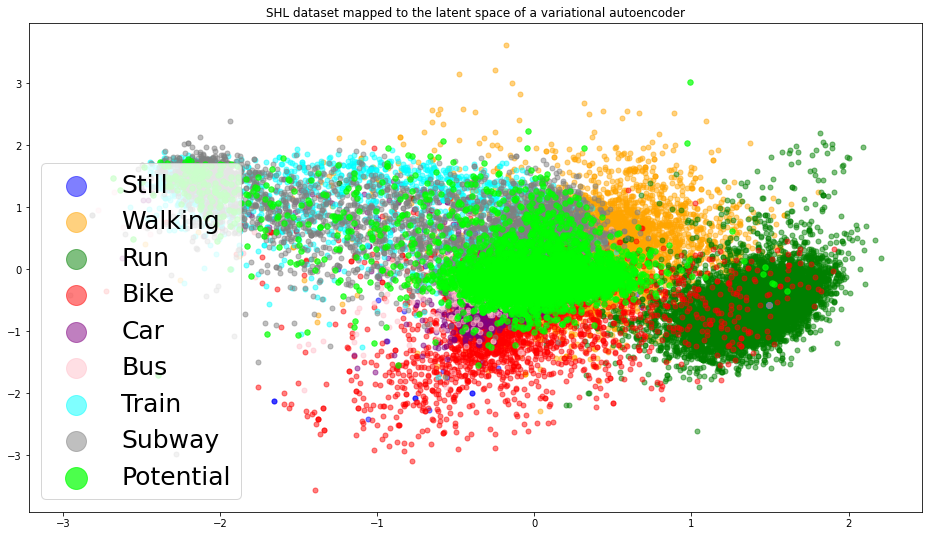

In [37]:
if len(X_pot)<5000:
  N_pot = len(X_pot)
else:
  N_pot = 5000
potential.plot_latent_space_with_pot(Y_pot.cpu(), Z_pot.cpu(),Y_no_pot.cpu(), Z_no_pot.cpu(),N_pot, N_no_pot = 30000 ,lat_var_1 = 0,lat_var_2 = 1)

**How did classification performance change:**
In this section it is studied how the confusion matrix changes when using the retrained classifier instead of the baseline classifier.

In [ ]:
# Load and initialize trained VAE:
fc_base = FC.FC(dropout_ratio_1).to(device)
fc_base = basic_functions.initialize_model(fc_base,dir_fc_base)
fc_base.eval()

trainloader_type = 'trainloader_pot'
dir_fc_best_w    = dir_hyper_folder + 'w_'+ str(w_eval) + '/' + trainloader_type + '/best_model.pth'
fc_best_w        = FC.FC(dropout_ratio_1).to(device)
fc_best_w        = basic_functions.initialize_model(fc_best_w,dir_fc_best_w)

Calculate confusion matrix of baseline classifier and confusion matrix of retrained classifier:

In [ ]:
y_pred = eval_FC.classifier_predict(fc_base,x_test,device)
conf_matrix_base = eval_FC.calc_confusion_matrix(y_pred,y_test)

y_pred = eval_FC.classifier_predict(fc_best_w,x_test,device)
conf_matrix_best = eval_FC.calc_confusion_matrix(y_pred,y_test)

**Confustion matrix difference**
Postive elements on the diagonal of the confusion matrix are marked green whereas negative ones are marked red. Vice versa for the off-diagonal elements.

Postivie elements on the diagonal implies that the number of true positives has increased, whereas negative elements implies that it has decreased. Vice vers holds for the off-diagonal elements.

In [ ]:
df = conf_matrix_best - conf_matrix_base

df.style.apply(hps.highlight_confusion_matrix_difference, axis=None)

,Still,Walking,Run,Bike,Car,Bus,Train,Subway
Still,972,-183,68,-97,-213,-189,-123,-235
Walking,583,-7027,246,60,147,5428,26,537
Run,8,-20,-180,68,0,121,0,3
Bike,947,-319,315,-1958,365,612,38,0
Car,13223,-5,43,-31,-8872,-4849,741,-250
Bus,9643,-163,192,-137,-1240,-8018,80,-357
Train,3881,-94,65,-55,97,-433,-868,-2593
Subway,1686,-24,27,-8,192,-18,780,-2635


In [ ]:
conf_matrix_base

,Still,Walking,Run,Bike,Car,Bus,Train,Subway
Still,10424,194,0,100,235,216,161,246
Walking,254,8201,17,82,3,22,4,144
Run,3,43,3979,30,1,0,0,1
Bike,105,424,128,5367,25,81,2,16
Car,565,5,1,33,9326,4876,182,333
Bus,338,168,1,145,1345,8169,214,398
Train,598,97,0,64,268,455,3340,2956
Subway,257,25,1,10,49,30,619,2999


In [ ]:
print(ws)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 0.999972, 0.999973, 0.999974, 0.999975, 0.999976, 0.999977, 0.999978, 0.999979, 0.99998, 0.999981, 0.999982, 0.999983, 0.999984, 0.999985, 0.999986, 0.999987, 0.999988, 0.999989, 0.99999]


In [ ]:
conf_matrix_best

,Still,Walking,Run,Bike,Car,Bus,Train,Subway
Still,11385,6,76,3,19,32,38,17
Walking,831,1146,297,153,148,5416,37,699
Run,9,17,3789,105,3,127,1,6
Bike,1043,94,449,3406,370,737,36,13
Car,13821,1,35,1,485,27,889,62
Bus,9946,9,195,7,118,144,315,44
Train,4505,7,50,10,371,19,2461,355
Subway,1914,0,20,2,251,13,1424,366


**Generate retrain dataset accroding to: z = mu + beta epsilon var**


Generate a retrainset, that contains multiple reconstructions of points with positive potential.

In [ ]:
X_pot_retrain, Y_pot_retrain = retrain_FC.generate_retrainset(X_pot,Y_pot,VAE_1,device)
trainloader_pot_rec_retrain  = lpd.generate_dataloader(X_pot,Y_pot, batch_size, shuffle = False)

**Evaluate dataset of points with positive potential:**
1. How does points with positive potential perform compared to points with negative potential on the baseline classifier and compared to overall dataset.
2. What is the reconstruction error of points with positive potential.

In [ ]:
torch.cuda.empty_cache()

First the performance of the baseline classifier on traindata, traindata with positive potential and traindata with negative potential is evaluated. This gives an idea on how well the baseline classifier is trained on the points with positive potential.

In [ ]:
df = eval_potential.evaluate_dataset_on_classifier(trainloader_pot, trainloader_no_pot, trainloader_no_shuffle,fc_base,device,criterion)
df.style.set_table_attributes("style='display:inline'").set_caption('Performance of classifier on traindata, traindata with postivie potential and traindata with negeative potential')

,Train,Pot,No Pot
Loss,1.444087,1.789754,1.311862
Accuracy,0.828829,0.479850,0.962331
F1 Score,0.827147,0.499259,0.963283


Next, traindata, traindata with postitive potential and traindata with negative potential are fed through the VAE to generate their reconstructed signal. The performance of VAE on those three datasets is evaluated. This gives an idea on how well the VAE is trained on the points with positive potential compared to the one with negative potential.

In [ ]:
X_pot_rec    = potential.map_dataloader_to_rec(trainloader_pot,VAE_1,device)
X_no_pot_rec = potential.map_dataloader_to_rec(trainloader_no_pot,VAE_1,device)
X_train_rec  = potential.map_dataloader_to_rec(trainloader_no_shuffle,VAE_1,device)

trainloader_pot_rec    = lpd.generate_dataloader(X_pot_rec,Y_pot, batch_size, shuffle = False)
trainloader_no_pot_rec = lpd.generate_dataloader(X_no_pot_rec,Y_no_pot, batch_size, shuffle = False)
trainloader_rec        = lpd.generate_dataloader(X_train_rec,y_train, batch_size, shuffle = False)

del X_pot_rec, X_no_pot_rec, X_train_rec

In [ ]:
df = eval_potential.evaluate_dataset_on_vae(trainloader_pot, trainloader_no_pot, trainloader,device,beta, VAE_1)
df.style.set_table_attributes("style='display:inline'").set_caption('Performance of VAE on traindata, traindata with postivie potential and traindata with negeative potential')

,Train,Pot,No Pot
Loss,4608.693318,1683.595509,5725.661827
Rec Loss,0.012216,0.004448,0.015182
KL Loss,38.085179,35.052949,39.243010


Last, the performance of the classifier on the reconstructed traindataset, reconstructed traindataset with postitive potential and reconstructed traindata with negative potential is evaluated. This gives an idea on how well the baseline classifier is trained on the reconstructed signal. Furthermore the difference between the accuracy performance of the original dataset and their reconstruction should not be too high. This would imply that the reconstructed signal do not represent the original dataset well.

In [ ]:
df = eval_potential.evaluate_dataset_on_classifier(trainloader_pot_rec, trainloader_no_pot_rec, trainloader_rec,fc_base,device,criterion)
df.style.set_table_attributes("style='display:inline'").set_caption('Performance of classifier on reconstructed traindata, reconstructed traindata with postivie potential and reconstructed traindata with negeative potential')
df 

,Train,Pot,No Pot
Loss,1.531726,1.995552,1.354246
Accuracy,0.738976,0.270742,0.918150
F1 Score,0.730657,0.272627,0.919228


Also evaluate the performance of the dataloader trainloader_pot_rec_retrain, containing multiple reconstructions of each point with postive potential.

In [ ]:
df = eval_potential.evaluate_dataset_on_classifier(trainloader_pot_rec_retrain, trainloader_no_pot_rec, trainloader_rec,fc_base,device,criterion)
df.style.set_table_attributes("style='display:inline'").set_caption('Performance of classifier on reconstructed traindata, reconstructed traindata with postivie potential and reconstructed traindata with negeative potential')
df

,Train,Pot,No Pot
Loss,1.531726,1.789754,1.354246
Accuracy,0.738976,0.479850,0.918150
F1 Score,0.730657,0.499259,0.919228
